### Install Packages and Import Dataset

In this notebook, we’ll be working with a data set from the palmerpenguins package. This dataset contains two variables—penguin bill and flipper length, both in millimeters—to determine whether there are distinct types of penguins in our data.

Here, there are no pre-defined labels. Investigating these features  might help us with species discovery and classification in a data-driven way!

This dataset was obtained from (https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data)

In [15]:
import numpy as np
import pandas as pd
from sklearn import set_config
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [7]:
# Output dataframes instead of arrays
set_config(transform_output="pandas")

#set seed for reproducibility
np.random.seed(10)

penguins = pd.read_csv("dataset/penguins.csv")
penguins

,bill_length_mm,flipper_length_mm
0,39.1,181
1,39.5,186
2,40.3,195
3,36.7,193
4,39.3,190
...,...,...
337,55.8,207
338,43.5,202
339,49.6,193
340,50.8,210


We will standardize our data so that prior to clustering to ensures that all features contribute equally to the distance calculations, preventing any single feature from dominating the results due to its scale.

In [45]:
scaler = StandardScaler()
standardized_penguins = scaler.fit_transform(penguins)

# Convert the standardized data back to a DataFrame
standardized_penguins = pd.DataFrame(standardized_penguins, columns=penguins.columns)

standardized_penguins


,bill_length_mm,flipper_length_mm
0,-0.884499,-1.418347
1,-0.811126,-1.062250
2,-0.664380,-0.421277
3,-1.324737,-0.563715
4,-0.847812,-0.777373
...,...,...
337,2.178824,0.433355
338,-0.077396,0.077258
339,1.041543,-0.563715
340,1.261662,0.647013


### Visualizing the Data

Now, let’s create a scatter plot to visualize the relationship between the two variables and see if we can detect subtypes or groups in our data set.

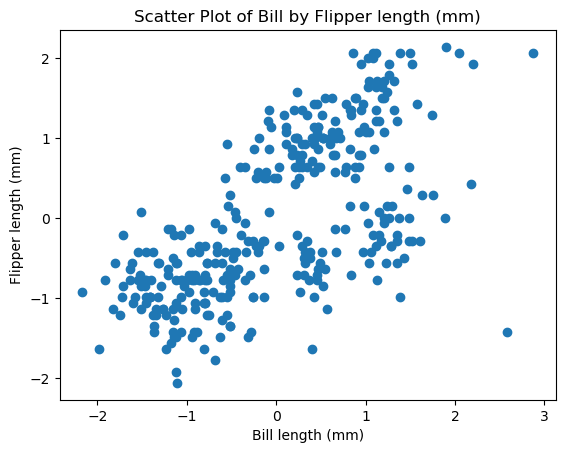

In [13]:
# Plot
plt.scatter(standardized_penguins["bill_length_mm"], standardized_penguins["flipper_length_mm"])

# Add labels and legend
plt.xlabel("Bill length (mm)")
plt.ylabel('Flipper length (mm)')
plt.title('Scatter Plot of Bill by Flipper length (mm)')
plt.show()

Based on the visualization, we might suspect there are a few subtypes of penguins within our data set. We can see roughly 3 groups of observations in Fig. 9.2, including:

1. a small flipper and bill length group,

2. a small flipper length, but large bill length group, and

3. a large flipper and bill length group.

Data visualization helps us see patterns with a few variables, but as the number of variables increases, it becomes harder to find groups. To systematically group data, we use clustering algorithms. This notebook focuses on **K-means clustering** and the elbow method to choose the number of clusters, which effectively organizes data into groups.

### K-means clustering

K-means works in two main steps to minimize the total within-cluster sum-of-squared-distances (WSSD), also called *inertia*:

1. **Center Update**: Calculate the new center of each cluster.
2. **Label Update**: Reassign each data point to the nearest cluster center.

These steps repeat until cluster assignments stabilize.

To perform K-means clustering in Python, it follows a similar workflow to classification and regression tasks. 

Step 1. To indicate that we are performing K-means clustering, we will create a KMeans model object. It takes at least one argument: the number of clusters `n_clusters`, which we set to 3.

Note that the K-means algorithm uses a random initialization of assignments, but since we set the random seed in the beginning of this notebook, the clustering will be reproducible.

In [51]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit(standardized_penguins)

/Users/juliagallucci/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2. Cluster visualization

The KMeans object contains useful information for visualizing and evaluating clusters. To start, you can visualize the clusters with a colored scatter plot. First, add the cluster assignments to your original penguins DataFrame using the `labels_` attribute of the KMeans object. This will help you see how the data points are grouped.

In [52]:
# Add cluster labels to the original DataFrame
standardized_penguins['Cluster'] = clusters.labels_
standardized_penguins

,bill_length_mm,flipper_length_mm,Cluster
0,-0.884499,-1.418347,0
1,-0.811126,-1.062250,0
2,-0.664380,-0.421277,0
3,-1.324737,-0.563715,0
4,-0.847812,-0.777373,0
...,...,...,...
337,2.178824,0.433355,2
338,-0.077396,0.077258,2
339,1.041543,-0.563715,2
340,1.261662,0.647013,1


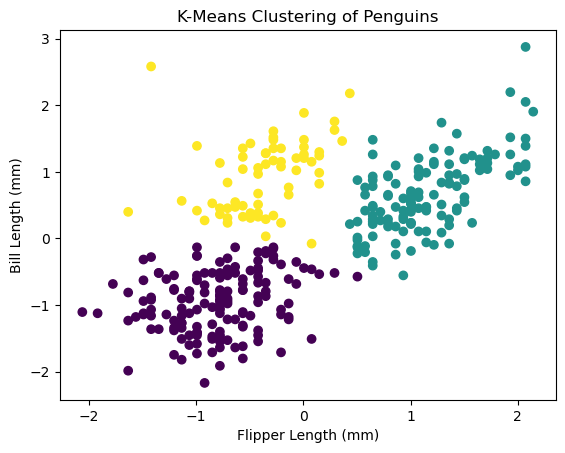

In [53]:
# Plot the clusters
plt.scatter(standardized_penguins['flipper_length_mm'], standardized_penguins['bill_length_mm'], c=standardized_penguins['Cluster'])
plt.xlabel('Flipper Length (mm)')
plt.ylabel('Bill Length (mm)')
plt.title('K-Means Clustering of Penguins')
plt.show()


Step 3. We also need to select K by finding where the “elbow” occurs in the plot of total WSSD versus the number of clusters. The total WSSD is stored in the `.inertia_` attribute of the clustering object (“inertia” is the term scikit-learn uses to denote WSSD).

In [54]:
clusters.inertia_

157.8153218752378

To calculate the total Within-Cluster Sum of Squares (WSSD) for different values of 
$k$, you can use a list comprehension to run K-means for each $k$ and store the results in a DataFrame. 

In [57]:
# Define a range of k values to test
ks = range(1, 10)

# Calculate WSSD for each k
wssds = [
    KMeans(n_clusters=k, random_state=0).fit(standardized_penguins).inertia_
    for k in ks
]

# Create a DataFrame with k values and their corresponding WSSD
penguin_clust_ks = pd.DataFrame({
    "k": ks,
    "wssd": wssds,
})


penguin_clust_ks

/Users/juliagallucci/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/juliagallucci/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/juliagallucci/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/juliagallucci/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

,k,wssd
0,1,876.868421
1,2,301.551552
2,3,157.815322
3,4,120.655059
4,5,95.182887
5,6,79.023047
6,7,67.450236
7,8,58.759534
8,9,53.320875


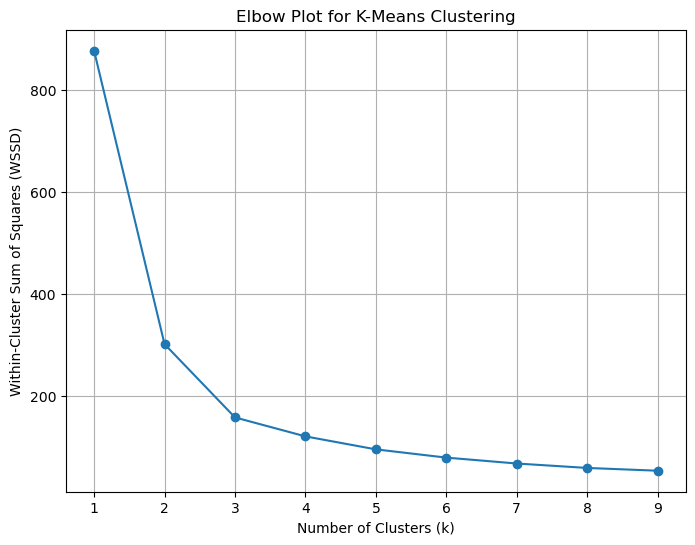

In [58]:
# Create the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(penguin_clust_ks['k'], penguin_clust_ks['wssd'], marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WSSD)')
plt.title('Elbow Plot for K-Means Clustering')
plt.xticks(penguin_clust_ks['k'])  # Optional: to ensure all k values are shown on the x-axis
plt.grid(True)
plt.show()


Three clusters seem to be the best choice because that's where the plot shows a clear "elbow," indicating a good balance between cluster count and WSSD reduction.

### Conclusion

In this notebook, we worked through exploratory analyses to identify meaningful subgroups (or clusters) in the data. Here's a summary of what we covered:

1. **Scaling**: We identify when it is necessary to scale variables before clustering.
2. **K-means clustering:** We implemented k-means clustering 
3. **Visualization:** We visualized the output of K-means clustering using a colored scatter plot.
4. **Elbow method:** We used the elbow method to choose the number of clusters for K-means. 


We hope this notebook has provided a practical understanding of data clustering,  and the application of machine learning algorithms like k-means. Feel free to experiment further with the dataset or the code to enhance your learning!